In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as geom
import shapely.ops as ops

from scipy import ndimage
from skimage.measure import regionprops
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


GROUP A — Parameters

In [ ]:
# ---- PARAMETERS ----
PIXEL_SIZE = 10  # meters (Sentinel-2 10 m)
PIXEL_AREA_HA = (PIXEL_SIZE * PIXEL_SIZE) / 10_000  # ha

MIN_OBJECT_AREA_HA = 0.2   # remove tiny noise objects


GROUP B — Connected Components (Per Date)

In [ ]:
def label_excavation_components(excavation_mask):
    """
    excavation_mask: xarray.DataArray (2D), values {0,1}
    """
    binary = excavation_mask.values.astype(bool)

    # 8-connected components
    labeled, num = ndimage.label(binary, structure=np.ones((3,3)))
    return labeled, num


GROUP C — Convert Components to Objects

In [ ]:
def extract_objects_for_date(
    date,
    excavation_mask,
    anomaly_map=None,
    transform=None
):
    """
    Returns GeoDataFrame of excavation objects for one date
    """

    labeled, num = label_excavation_components(excavation_mask)

    objects = []

    props = regionprops(labeled)

    for prop in props:
        pixel_count = prop.area
        area_ha = pixel_count * PIXEL_AREA_HA

        # Remove tiny noise
        if area_ha < MIN_OBJECT_AREA_HA:
            continue

        # Build polygon from pixel coordinates
        coords = prop.coords  # (row, col)

        polys = []
        for r, c in coords:
            x, y = excavation_mask.x.values[c], excavation_mask.y.values[r]
            polys.append(
                geom.box(
                    x - PIXEL_SIZE/2,
                    y - PIXEL_SIZE/2,
                    x + PIXEL_SIZE/2,
                    y + PIXEL_SIZE/2
                )
            )

        polygon = ops.unary_union(polys)

        # Compactness = 4πA / P²
        perimeter = polygon.length
        compactness = (
            4 * np.pi * polygon.area / (perimeter ** 2)
            if perimeter > 0 else 0
        )

        # Median anomaly (optional)
        median_anomaly = None
        if anomaly_map is not None:
            vals = anomaly_map.values[labeled == prop.label]
            median_anomaly = np.nanmedian(vals)

        objects.append({
            "date": date,
            "geometry": polygon,
            "area_ha": area_ha,
            "compactness": compactness,
            "median_anomaly": median_anomaly
        })

    # ---- SAFE RETURN ----
    if len(objects) == 0:
        return gpd.GeoDataFrame(
            columns=[
                "date",
                "geometry",
                "area_ha",
                "compactness",
                "median_anomaly"
            ],
            geometry="geometry",
            crs="EPSG:4326"
        )

    return gpd.GeoDataFrame(
        objects,
        geometry="geometry",
        crs="EPSG:4326"
)




GROUP D — Track Object Age (First Detection)

In [ ]:
def assign_object_age(all_objects):
    """
    all_objects: GeoDataFrame with columns [date, geometry, ...]
    """

    all_objects = all_objects.sort_values("date").reset_index(drop=True)

    all_objects["start_date"] = None
    all_objects["confidence"] = 0.0

    active_geoms = []

    for idx, row in all_objects.iterrows():
        geom_now = row.geometry
        date_now = row.date

        matched = False
        for g, d0 in active_geoms:
            if geom_now.intersects(g):
                all_objects.at[idx, "start_date"] = d0
                matched = True
                break

        if not matched:
            all_objects.at[idx, "start_date"] = date_now
            active_geoms.append((geom_now, date_now))

        # Confidence: grows with persistence
        age_days = (date_now - all_objects.at[idx, "start_date"]).days
        all_objects.at[idx, "confidence"] = min(1.0, age_days / 90)

    return all_objects


GROUP E — Run Object Formation for ALL DATES

In [ ]:
import ipynb 
from ipynb.fs.defs.temporial_state_pipeline import run_excavation_pipeline

In [ ]:
monitor_df = pd.read_csv("results/monitoring_anomaly_scores.csv")

monitor_df, state_maps, excavation_maps = run_excavation_pipeline(
    monitor_df,
    window=3,
    anomaly_quantile=0.90,
    persistence_days=30
)


/home/manikanta/Desktop/aurora/temporial_state_pipeline.ipynb:102: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "            if states[i] == 1:\n",


In [ ]:
# temporial anomaly maps

from ipynb.fs.defs.featurecube import build_feature_cube
from ipynb.fs.defs.temporial_anomaly_pipleine import temporal_anomaly_scoring


In [ ]:
DATA_DIR = "content/mine01/monitor"
AOI = {"type":"Polygon","coordinates":[[[81.1540853393247,21.192409387913486],[81.1540573545225,21.19240716153938],[81.15402929421587,21.192408272781766],[81.15400160916909,21.192412703789593],[81.1539747441181,21.192420383382466],[81.15394913062669,21.19243118819471],[81.15392518015352,21.19244494465619],[81.15390327744277,21.192461431781368],[81.15388377434329,21.19248038471881],[81.15386698415662,21.19250149900575],[81.153853176604,21.192524435459198],[81.1538425734937,21.192548825624286],[81.15383534515738,21.192574277693538],[81.15383160771387,21.192600382800325],[81.15383142120422,21.192626721587565],[81.15383478862628,21.192652870944112],[81.15402876354473,21.193632514653288],[81.1533611590414,21.19403782960822],[81.15333861820847,21.194053498997295],[81.15331836942244,21.194071714068702],[81.15330073732551,21.194092182787067],[81.15328600460752,21.19411457698494],[81.15327440747441,21.194138537624458],[81.15326613186016,21.194163680552997],[81.15326131044677,21.194189602662878],[81.15326002053592,21.19421588835357],[81.15326228281037,21.194242116195422],[81.15353860668199,21.19602838075773],[81.15354494409702,21.196055985653967],[81.15355521340598,21.196082530018717],[81.15356922500995,21.196107523766145],[81.15358672021567,21.196130505439243],[81.15498677363634,21.197727820950835],[81.15500178256848,21.197743287327015],[81.1550183730142,21.197757260784606],[81.15641842754856,21.198822128399758],[81.15644127733951,21.198837365806295],[81.15646599591159,21.198849775462442],[81.15649218755777,21.198859158708],[81.1565194329891,21.198865365331304],[81.15654729604701,21.198868295973522],[81.15657533068526,21.19886790371947],[81.15660308811104,21.19886419484857],[81.15663012396931,21.198857228734308],[81.15710909036616,21.198702651613694],[81.15713480644565,21.198692616069653],[81.15715897695071,21.198679634496592],[81.1571812200086,21.19866391199205],[81.1572011841989,21.198645696958035],[81.15721855410575,21.19862527717617],[81.15723305530092,21.19860297526119],[81.15724445867978,21.198579143563595],[81.1572525840805,21.19855415860283],[81.1572573031308,21.19852841511904],[81.15731256771447,21.198047508056423],[81.15731376802916,21.19801981959663],[81.15731102938082,21.19799222753715],[81.15730440046829,21.19796522250072],[81.15729399916421,21.197939284671502],[81.15728001041894,21.19791487525728],[81.15726268297182,21.197892428288284],[81.15700347531791,21.19759988222633],[81.15806578245038,21.195521579843607],[81.15807605075916,21.195497836494543],[81.1580831254837,21.19547308859064],[81.15808689908317,21.195447712322707],[81.15808731419735,21.195422093433297],[81.15808436451765,21.195396621352586],[81.15807809488368,21.195371683279113],[81.15806860060098,21.195347658293823],[81.15805602599261,21.195324911597563],[81.15645333057125,21.192817257521707],[81.15643749203588,21.192795685673932],[81.15641888609171,21.19277615349095],[81.1563978082765,21.19275897122183],[81.15637459339109,21.19274441178986],[81.15634961018111,21.19273270645689],[81.15632325547985,21.192724041150285],[81.15629594790525,21.19271855350981],[81.1540853393247,21.192409387913486]]]}

In [ ]:
monitoring_cube =  build_feature_cube(DATA_DIR, AOI)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

In [ ]:
# Load trained baseline model
import joblib
import os

# 1. Define the path 
mine_id = "MINE_001"
model_dir = "baseline_models" 
model_path = os.path.join(model_dir, f"{mine_id}_baseline_model.joblib")

# 2. Load the entire bundle
model_bundle = joblib.load(model_path)

BaselineModel = model_bundle

In [ ]:
monitor_d, anomaly_maps, stats  = temporal_anomaly_scoring(
    monitoring_cube=monitoring_cube,
    BaselineModel=BaselineModel
)

/home/manikanta/anaconda3/envs/mining/lib/python3.12/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
all_objects = []

for date in excavation_maps.keys():
    gdf = extract_objects_for_date(
        date=date,
        excavation_mask=excavation_maps[date],
        anomaly_map=anomaly_maps.get(date)
    )

    if not gdf.empty:
        all_objects.append(gdf)


/tmp/ipykernel_19260/3351120694.py:53: RuntimeWarning: All-NaN slice encountered
  median_anomaly = np.nanmedian(vals)
/tmp/ipykernel_19260/3351120694.py:53: RuntimeWarning: All-NaN slice encountered
  median_anomaly = np.nanmedian(vals)


In [ ]:
for i, gdf in enumerate(all_objects):
    print(i, type(gdf), gdf.empty, gdf.columns)


0 <class 'geopandas.geodataframe.GeoDataFrame'> False Index(['date', 'geometry', 'area_ha', 'compactness', 'median_anomaly'], dtype='object')
1 <class 'geopandas.geodataframe.GeoDataFrame'> False Index(['date', 'geometry', 'area_ha', 'compactness', 'median_anomaly'], dtype='object')
2 <class 'geopandas.geodataframe.GeoDataFrame'> False Index(['date', 'geometry', 'area_ha', 'compactness', 'median_anomaly'], dtype='object')


In [ ]:
objects_gdf = gpd.GeoDataFrame(
    pd.concat(all_objects, ignore_index=True),
    geometry="geometry",
    crs="EPSG:4326"
)

In [ ]:
objects_gdf.head()

,date,geometry,area_ha,compactness,median_anomaly
0,2023-05-08,"POLYGON ((86.15554 16.19706, 76.15581 16.19706...",0.21,0.785398,1.754103
1,2023-09-17,"POLYGON ((76.15339 16.19404, 76.15339 16.19413...",26.64,0.785398,NaN
2,2023-12-31,"POLYGON ((76.15339 16.19404, 76.15339 16.19413...",26.64,0.785398,NaN


In [ ]:
objects_gdf = assign_object_age(objects_gdf)


GROUP F — Visual Sanity Check

In [ ]:
mine = gpd.read_file("content/mines/mines_cils.shp")
mine_sel = mine.iloc[[1]]

In [ ]:
objects_gdf["date"].__len__()


3

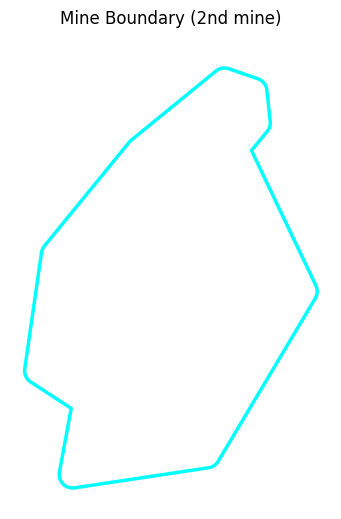

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

mine_sel.plot(
    ax=ax,
    facecolor="none",      # 🔒 ensures NO fill
    edgecolor="cyan",
    linewidth=2.5
)

ax.set_title("Mine Boundary (2nd mine)")
ax.set_axis_off()
plt.show()


In [ ]:
print("objects CRS:", objects_gdf.crs)
print("mine_sel CRS:", mine_sel.crs)


objects CRS: EPSG:4326
mine_sel CRS: EPSG:4326


In [ ]:
sample_date = objects_gdf["date"].iloc[2]

In [ ]:
print("Objects bounds:")
print(objects_gdf[objects_gdf["date"] == sample_date].total_bounds)

print("\nMine bounds:")
print(mine_sel.total_bounds)


Objects bounds:
[76.15330472 16.19244912 86.15804262 26.19882634]

Mine bounds:
[81.15326002 21.19240716 81.15808731 21.1988683 ]


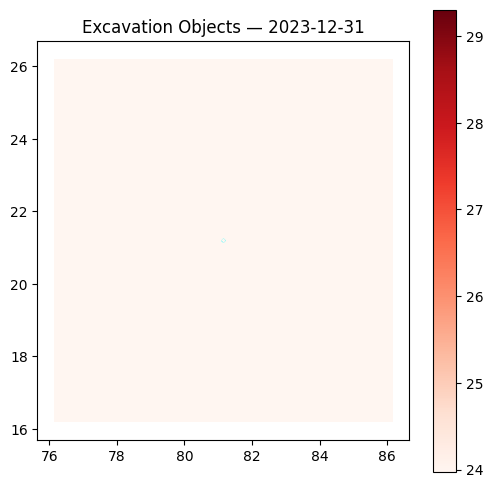

In [ ]:
sample_date = objects_gdf["date"].iloc[2]

fig, ax = plt.subplots(figsize=(6,6))


objects_gdf[objects_gdf["date"] == sample_date].plot(
    ax=ax,
    column="area_ha",
    cmap="Reds",
    legend=True,
    alpha=0.9
)

# Plot mine boundary ON TOP
mine_sel.plot(
    ax=ax,
    facecolor="none",     # 🔒 THIS prevents cyan fill
    edgecolor="cyan",
    linewidth=2.5,
    zorder=10
)


ax.set_title(f"Excavation Objects — {sample_date.date()}")


plt.show()


Tests and proofs

In [ ]:
for d, mask in excavation_maps.items():
    print(d, int(mask.sum()))


2023-01-08 00:00:00 0
2023-01-28 00:00:00 0
2023-02-02 00:00:00 0
2023-02-27 00:00:00 0
2023-03-04 00:00:00 0
2023-03-29 00:00:00 0
2023-04-03 00:00:00 0
2023-04-28 00:00:00 0
2023-05-08 00:00:00 27
2023-05-28 00:00:00 0
2023-06-02 00:00:00 0
2023-06-27 00:00:00 0
2023-07-02 00:00:00 0
2023-07-27 00:00:00 0
2023-08-01 00:00:00 0
2023-08-31 00:00:00 2
2023-09-05 00:00:00 0
2023-09-17 00:00:00 0
2023-10-05 00:00:00 0
2023-10-30 00:00:00 0
2023-11-04 00:00:00 0
2023-11-29 00:00:00 0
2023-12-09 00:00:00 0
2023-12-31 00:00:00 0
2024-01-03 00:00:00 0
2024-01-28 00:00:00 0
2024-02-02 00:00:00 0
2024-02-27 00:00:00 0
2024-03-08 00:00:00 0
2024-03-28 00:00:00 0
2024-04-02 00:00:00 0
2024-04-27 00:00:00 0
2024-05-02 00:00:00 0
2024-05-27 00:00:00 0
2024-06-01 00:00:00 0
2024-07-01 00:00:00 0
2024-07-31 00:00:00 0
2024-08-10 00:00:00 0
2024-08-25 00:00:00 0
2024-09-04 00:00:00 0
2024-09-19 00:00:00 0
2024-09-29 00:00:00 0
2024-10-04 00:00:00 0
2024-10-29 00:00:00 0
2024-11-03 00:00:00 1
2024-11-2

In [45]:
print("objects CRS:", objects_gdf.crs)
print("mine CRS:", mine.crs)


objects CRS: EPSG:4326
mine CRS: EPSG:4326


In [46]:
mine_plot = mine.to_crs(objects_gdf.crs)
